In [264]:
import seaborn as sns
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from PIL import Image
import pytesseract

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from umap import UMAP 

from scipy.spatial import distance_matrix

In [277]:
raws = pytesseract.image_to_boxes(Image.open('pics/image5.png')).split('\n')[:-1]
matrix = [[int(el) for el in raw.split(' ')[1:-1]] for raw in raws]

In [278]:
dataset = (pd.DataFrame(np.array(matrix)).rename({
    0: 'x1',
    1: 'y1',
    2: 'x2',
    3: 'y2' 
    }, axis=1)
    .astype({
            'x1': int,
            'x2': int,
            'y1': int,
            'y2': int,
    }))

In [279]:
dataset['x_centroid'] = dataset['x1'] + (dataset['x2'] - dataset['x1'] /2)
dataset['y_centroid'] = dataset['y1'] + (dataset['y2'] - dataset['y1'] /2)
dataset['zero'] = 0
dataset['shape'] = abs(dataset['y2'] - dataset['y1']) * abs(dataset['x2'] - dataset['x1'])

In [280]:
x_matrix = distance_matrix(dataset[['x_centroid', 'zero']], dataset[['x_centroid', 'zero']])
x_distances = x_matrix.flatten()

y_matrix = distance_matrix(dataset[['y_centroid', 'zero']], dataset[['y_centroid', 'zero']])
y_distances = y_matrix.flatten()

x_mean_dist = np.mean(x_distances)
y_mean_dist = np.mean(y_distances)

x_std_dist = np.std(x_distances)
y_std_dist = np.std(y_distances)

print(f'{x_std_dist} - {y_std_dist}')

123.55048292748998 - 224.32831202640892


In [281]:
dataset['x_centroid'] /= ((y_mean_dist / y_std_dist) / (x_mean_dist / x_std_dist)) * 1

In [282]:
slice_list = [i for i in range(1, 10)]

In [283]:
l2_distance = distance_matrix(dataset[['y_centroid', 'x_centroid']], dataset[['y_centroid', 'x_centroid']])
l2_matrix_n_neigh = np.sort(l2_distance, axis=0).take(slice_list, axis=0).flatten()

In [284]:
# sns.histplot(l2_matrix_n_neigh)

In [285]:
epsilon = np.percentile(l2_matrix_n_neigh, 75)

In [286]:
epsilon

26.88226132214262

In [287]:
clustered = dataset.copy()

clustering = DBSCAN(eps=epsilon, min_samples=4).fit(dataset[['y_centroid', 'x_centroid']])
clustered['cluster'] = clustering.labels_
cluster_order = clustered.groupby('cluster').agg({'x_centroid': np.mean, 'y_centroid': np.mean}).sort_values(['y_centroid', 'x_centroid'], ascending=False).reset_index().reset_index()[['index', 'cluster']]
clustered = clustered.merge(cluster_order.rename({'index': 'cluster_order'}, axis=1), on='cluster', how='right')

38

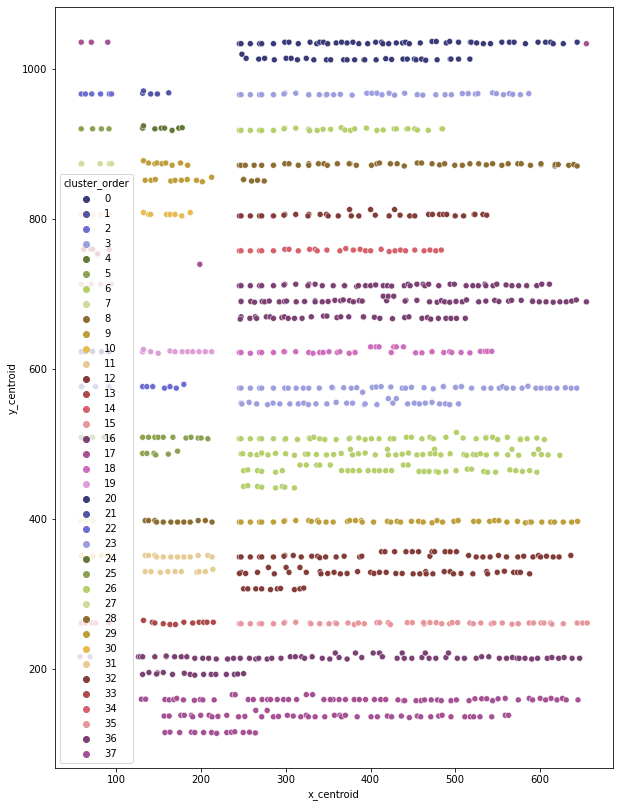

In [288]:
_, axs = plt.subplots(figsize=(10, 14))

sns.scatterplot(data=clustered, x='x_centroid', y='y_centroid', hue='cluster_order', ax=axs, palette='tab20b')

clustered.cluster_order.nunique()